## Figure 6

Code to reproduce Figure 6 - Zonal mean SAOD and TOC plots for UKESM1.1, GloSSAC, and Bodeker data.

Data used:
- UKESM1.1 simulations with 1991 pinatubo eruption - SAOD and TOC
    - filenames: pinatubo_monthly_toc.nc, pinatubo_control_monthly_toc.nc, pinatubo_monthly_saod.nc, pinatubo_control_monthly_saod.nc
- GloSSAC v.2.22 data
    - filename: GloSSAC_V2.22.nc
- Bodeker v3.5.2 data
    - filenames: BSFilledTCO_V3.5.2_*_Monthly.nc

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [2]:
def calc_saod(df):
    aitken_soluble = df.m01s02i251[:,2,:,:]
    accum_soluble = df.m01s02i252[:,2,:,:]
    coarse_soluble = df.m01s02i253[:,2,:,:]    
    aitken_insoluble = df.m01s02i254[:,2,:,:]
    
    SAOD_sum = aitken_soluble + accum_soluble + coarse_soluble + aitken_insoluble# + accum_insoluble + coarse_insoluble
    
    weights = np.cos(np.deg2rad(SAOD_sum.latitude))
    weights.name = "weights"
    
    SAOD_sum_weighted = SAOD_sum.weighted(weights)

    SAOD_zonalmean = SAOD_sum_weighted.mean("longitude")

    SAOD_globalmean = SAOD_sum_weighted.mean(("longitude", "latitude"))    

    return SAOD_zonalmean, SAOD_globalmean

def calc_toc(df):

    weights = np.cos(np.deg2rad(df.latitude))
    weights.name = "weights"
    
    sum_weighted = df.weighted(weights)

    zonalmean = sum_weighted.mean("longitude")

    globalmean = sum_weighted.mean(("longitude", "latitude"))    

    return zonalmean, globalmean


def calc_antarc_toc(df):

    df = df[:,0:24,:]
    weights = np.cos(np.deg2rad(df.latitude))
    weights.name = "weights"
    
    sum_weighted = df.weighted(weights)

    zonalmean = sum_weighted.mean("longitude")

    globalmean = sum_weighted.mean(("longitude", "latitude"))    

    return globalmean

## Read files

In [3]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/Pinatubo_HIST')

# Load UKESM run data
hist_ozone = {}
hist_ozone['pinatubo'] = xr.open_dataset('pinatubo_monthly_toc.nc')
hist_ozone['control'] = xr.open_dataset('pinatubo_control_monthly_toc.nc')

hist_saod = {}
hist_saod['pinatubo'] = xr.open_dataset('pinatubo_monthly_saod.nc')
hist_saod['control'] = xr.open_dataset('pinatubo_control_monthly_saod.nc')

## Load GloSSAC
glossac = xr.open_dataset('/home/users/mmc70/Notebooks/Ozone_analysis/Glossac/GloSSAC_V2.22.nc')

# Load Bodeker datasets
base_path = '/home/users/mmc70/Notebooks/Ozone_analysis/Bodeker/'
file_pattern = 'BSFilledTCO_V3.5.2_{}_Monthly.nc'

years = range(1986, 1994)
datasets = []
zonal_means = []
global_means = []

for year in years:
    filepath = base_path + file_pattern.format(year)
    dataset = xr.open_dataset(filepath)
    datasets.append(dataset)
    
    zonal_mean, global_mean = calc_toc(dataset.tco)
    zonal_means.append(zonal_mean)
    global_means.append(global_mean)

# Create the control dataset (1979-1990)
BD_zonal_control = xr.concat(zonal_means[:5], dim='time')
BD_global_control = xr.concat(global_means[:5], dim='time')

# Create the main dataset (1991-1993)
BD_zonal = xr.concat(zonal_means[5:], dim='time')
BD_global = xr.concat(global_means[5:], dim='time')

BD_zonal_control_gb = BD_zonal_control.groupby('time.month').mean('time')
BD_global_control_gb = BD_global_control.groupby('time.month').mean('time')

## Plots

In [4]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=16)          # controls default text sizes          
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

In [5]:
ens_saod = hist_saod['pinatubo'].mean(dim='ensemble')
ens_control_saod = hist_saod['control'].mean(dim='ensemble')

zonal_saod, global_saod = calc_saod(ens_saod)
zonal_control_saod, global_control_saod = calc_saod(ens_control_saod)

In [65]:
# Slice 1991 to 1994, 525nm
sliced_glossac = glossac.Glossac_Aerosol_Optical_Depth[144:144+12*3,:,2]

sliced_glossac = sliced_glossac.fillna(0)
time_coords = pd.to_datetime(sliced_glossac.time.values, format='%Y%m')
sliced_glossac = sliced_glossac.assign_coords(time=time_coords)
weights = np.cos(np.deg2rad(sliced_glossac.lat))
weights.name = "weights"
SAOD_weighted = sliced_glossac.weighted(weights)
glossac_mean = SAOD_weighted.mean("lat")
glossac_zonal_mean = SAOD_weighted.mean("time")

# 1979-1990 mean as control
#sliced_glossac_control = glossac.Glossac_Aerosol_Optical_Depth[:144,:,2]
# 1986-1990 mean as control
sliced_glossac_control = glossac.Glossac_Aerosol_Optical_Depth[12*7:144,:,2]


# change the time array to datetime coordinates for groupby
data_array = sliced_glossac_control.fillna(0)
time_coords = pd.to_datetime(data_array.time.values, format='%Y%m')
data_array = data_array.assign_coords(time=time_coords)

zonal_glossac_control = data_array.groupby('time.month').mean('time')
weights = np.cos(np.deg2rad(zonal_glossac_control.lat))
weights.name = "weights"
SAOD_weighted = zonal_glossac_control.weighted(weights)
glossac_control_global_mean = SAOD_weighted.mean(dim=["lat"])

In [66]:
ens_toc = hist_ozone['pinatubo'].m01s50i219.mean(dim='ensemble')
ens_control_toc = hist_ozone['control'].m01s50i219.mean(dim='ensemble')

zonal_toc, global_toc = calc_toc(ens_toc)
antarc_toc = calc_antarc_toc(ens_toc)

zonal_control_toc, global_control_toc = calc_toc(ens_control_toc)
antarc_control_toc = calc_antarc_toc(ens_control_toc)

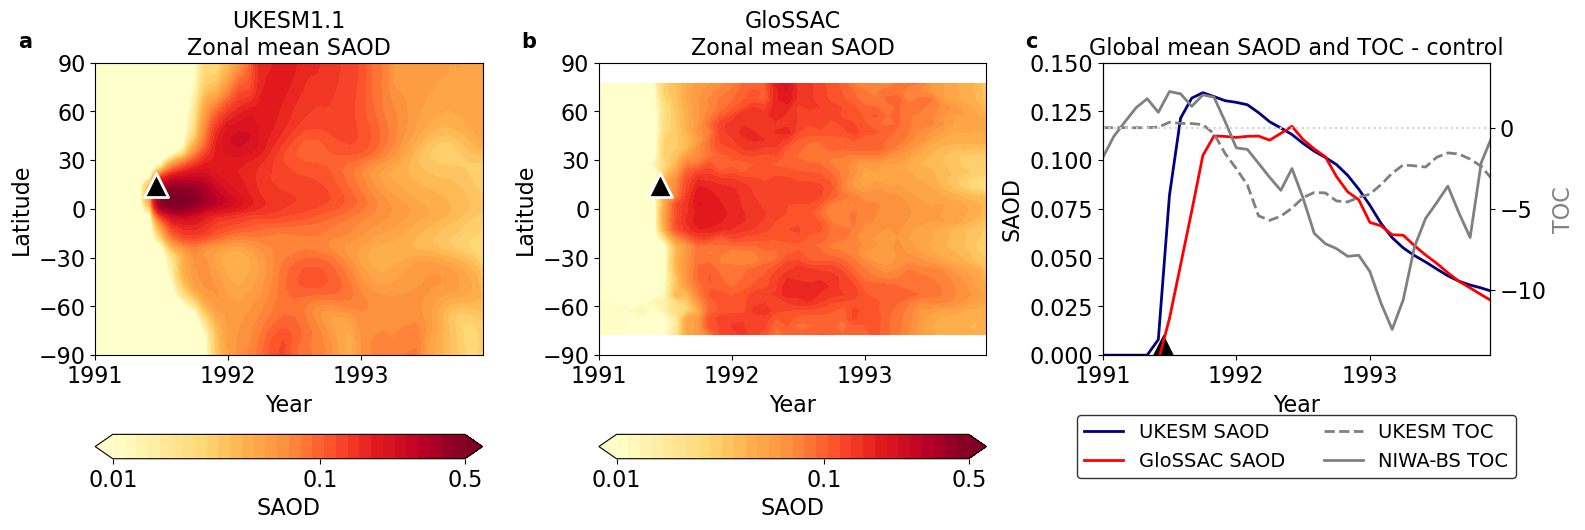

In [68]:
fig1 = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[18, 1.5])
ax1 = fig1.add_subplot(gs[0, 0])
ax2 = fig1.add_subplot(gs[0, 1])
ax3 = fig1.add_subplot(gs[0, 2])

# Plot 1: UKESM1.1
ax1.text(-0.2, 1.05, 'a', transform=ax1.transAxes, fontsize=15, fontweight='bold')

latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X, Y = np.meshgrid(time, latitudes)

levels = np.logspace(np.log10(0.01), np.log10(0.5), 31)

contour1 = ax1.contourf(X, Y, zonal_saod.transpose(), levels=levels, cmap='YlOrRd', extend='both',
                       norm=LogNorm(vmin=0.01, vmax=0.5))
ax1.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

ax1.set_title('UKESM1.1\nZonal mean SAOD')
ax1.set_xlabel('Year')
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.set_ylabel('Latitude')
ax1.set_xticks([1991, 1992, 1993])


# Plot 2: ML-TOMCAT
ax2.text(-0.2, 1.05, 'b', transform=ax2.transAxes, fontsize=15, fontweight='bold')
latitudes = sliced_glossac.lat
time = np.arange(1991,1994,1/12)
X, Y = np.meshgrid(time, latitudes)

levels = np.logspace(np.log10(0.01), np.log10(0.5), 31)

contour2 = ax2.contourf(X, Y, sliced_glossac.transpose(), levels=levels, cmap='YlOrRd', extend='both',
                       norm=LogNorm(vmin=0.01, vmax=0.5))
ax2.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)


ax2.set_title('GloSSAC\nZonal mean SAOD')
ax2.set_xlabel('Year')
ax2.set_yticks(np.arange(-90, 91, 30))
ax2.set_ylabel('Latitude')
ax2.set_xticks([1991, 1992, 1993])


# Plot 3: SAOD time series
ax3.text(-0.2, 1.05, 'c', transform=ax3.transAxes, fontsize=15, fontweight='bold')
time = np.arange(1991,1994,1/12)

ax3.plot(time, global_saod - global_control_saod, label='UKESM SAOD', color = 'navy', lw = 2)
ax3.plot(time, glossac_mean.groupby('time.month') - glossac_control_global_mean, label='GloSSAC SAOD', color = 'red', lw = 2)

ax3_right = ax3.twinx()
ax3_right.plot(time, global_toc - global_control_toc, label='UKESM TOC', ls = '--', lw = 2, color = 'grey')
ax3_right.plot(time, BD_global.groupby('time.month') - BD_global_control_gb, label='NIWA-BS TOC',color = 'grey', lw = 2)
ax3_right.axhline(0, color='lightgrey',ls='dotted')

ax3.scatter(1991.45,0, color='k', ec = 'white', marker='^', s=1200, lw=2)

ax3.set_title('Global mean SAOD and TOC - control')
ax3.set_xlabel('Year')
ax3.set_xticks([1991, 1992, 1993])
ax3.set_ylabel('SAOD')
ax3.set_ylim(0,0.15)
ax3.set_xlim(1991,1993.9)
ax3_right.set_ylabel('TOC', color='grey')
ax3_right.set_ylim(-14,4)


cbar_ax = fig1.add_subplot(gs[1, 0])
cbar = fig1.colorbar(contour2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SAOD')
cbar.set_ticks([0.01, 0.1, 0.5])
cbar.set_ticklabels(['0.01', '0.1', '0.5'])

cbar_ax = fig1.add_subplot(gs[1, 1])
cbar = fig1.colorbar(contour2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SAOD')
cbar.set_ticks([0.01, 0.1, 0.5])
cbar.set_ticklabels(['0.01', '0.1', '0.5'])


legend_ax = fig1.add_subplot(gs[1, 2])
legend_ax.axis('off')
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_right.get_legend_handles_labels()
legend_ax.legend(lines1 + lines2, labels1 + labels2, loc='center', ncol=2, fontsize=14, frameon=True)

plt.subplots_adjust(top=0.88, bottom=0.22, hspace=0.5, wspace=0.3)
plt.show()

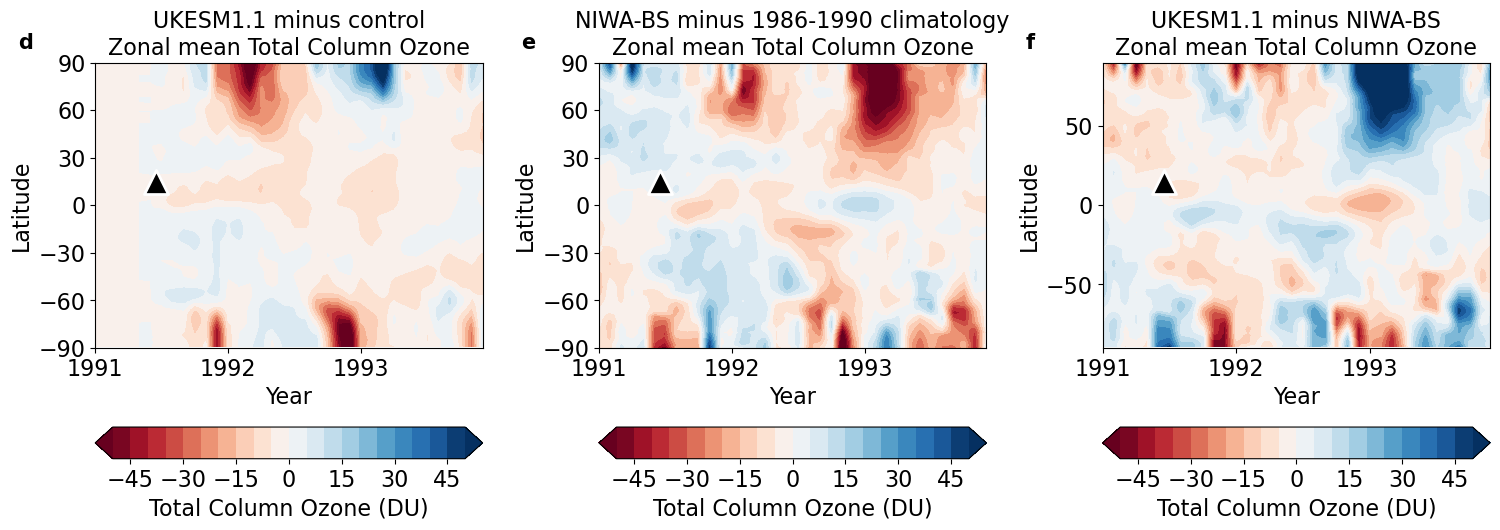

In [61]:
fig1 = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[18, 2])
ax1 = fig1.add_subplot(gs[0, 0])
ax2 = fig1.add_subplot(gs[0, 1])
ax3 = fig1.add_subplot(gs[0, 2])

# Plot 1: UKESM1.1
ax1.text(-0.2, 1.05, 'd', transform=ax1.transAxes, fontsize=15, fontweight='bold')

latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

diff = zonal_toc - zonal_control_toc

contour1 = ax1.contourf(X, Y, diff.transpose(), levels=levels, cmap='RdBu', extend='both')
ax1.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)

ax1.set_title('UKESM1.1 minus control\nZonal mean Total Column Ozone')
ax1.set_xlabel('Year')
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.set_ylabel('Latitude')
ax1.set_xticks([1991, 1992, 1993])


# Plot 2: ML-TOMCAT
ax2.text(-0.2, 1.05, 'e', transform=ax2.transAxes, fontsize=15, fontweight='bold')
latitudes = BD_zonal.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

diff = BD_zonal.groupby('time.month') - BD_zonal_control_gb

contour2 = ax2.contourf(X, Y, diff.transpose(), levels=levels, cmap='RdBu', extend='both')
ax2.scatter(1991+165/360, 15, marker='^', color='k', s=300, ec='white',lw=2)
ax2.set_title('NIWA-BS minus 1986-1990 climatology\nZonal mean Total Column Ozone')
ax2.set_xlabel('Year')
ax2.set_yticks(np.arange(-90, 91, 30))
ax2.set_ylabel('Latitude')
ax2.set_xticks([1991, 1992, 1993])

# Plot 3: UKESM1.1 - Bodeker
# Match the time dimension of the two datasets
BD_time = BD_zonal.time
zonal_toc['time'] = BD_time
zonal_control_toc['time'] = BD_time

diff_toc = zonal_toc - zonal_control_toc
diff_BD = BD_zonal.groupby('time.month') - BD_zonal_control_gb


target_lat = zonal_toc.latitude
target_time = zonal_toc.time

# Interpolate both datasets
interpolated_data1 = diff_toc.interp(**{'latitude': target_lat, 
                                         'time': target_time})

interpolated_data2 = diff_BD.interp(**{'latitude': target_lat, 
                                         'time': target_time})
    
# Calculate difference
difference = interpolated_data1 - interpolated_data2

ax3.text(-0.2, 1.05, 'f', transform=ax3.transAxes, fontsize=15, fontweight='bold')
latitudes = zonal_toc.latitude
time = np.arange(1991,1994,1/12)
X,Y = np.meshgrid(time, latitudes)

levels = np.linspace(-50, 50, 21)

contour3 = ax3.contourf(X, Y, difference.transpose(), levels=levels, cmap='RdBu', extend = 'both')
ax3.scatter(1991+165/360, 15, marker='^', color = 'k', s = 300, ec = 'white', lw=2)

ax3.set_title('UKESM1.1 minus NIWA-BS\nZonal mean Total Column Ozone')
ax3.set_xlabel('Year')
ax3.set_xticks([1991, 1992, 1993])
ax3.set_ylabel('Latitude')
ax3.set_ylim(-90,90)
ax3.set_xlim(1991,1993.9)


cbar_ax = fig1.add_subplot(gs[1, 0])
cbar = fig1.colorbar(contour1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Total Column Ozone (DU)')

cbar_ax = fig1.add_subplot(gs[1, 1])
cbar = fig1.colorbar(contour2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Total Column Ozone (DU)')

cbar_ax = fig1.add_subplot(gs[1, 2])
cbar = fig1.colorbar(contour3, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Total Column Ozone (DU)')

plt.subplots_adjust(top=0.88, bottom=0.22, hspace=0.5, wspace=0.3)
plt.show()